# Decision Tree (tau) [all]
This is a simple, yet powerful algorithm that can be used for both regression and classification problems. It works well with categorical data, as well as data with non-linear relationships.

https://scikit-learn.org/stable/modules/tree.html#regression

tree.DecisionTreeRegressor()

{'ccp_alpha': 0.0,   
 'criterion': 'squared_error',   
 'max_depth': None,   
 'max_features': None,   
 'max_leaf_nodes': None,   
 'min_impurity_decrease': 0.0,   
 'min_samples_leaf': 1,   
 'min_samples_split': 2,   
 'min_weight_fraction_leaf': 0.0,   
 'random_state': None,   
 'splitter': 'best'}   
 
**_bayesian hyperparameter tuning_**

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize, space
from skopt.space import Real, Integer
import sys

from validation import cross_validation
from validation import performance_test_shifted

date_format = '%Y-%m-%d'

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
# config 'all', 'vif_5' or 'vif_10'
vif = 'all'

# config model
ml_algorithm = tree.DecisionTreeRegressor
filename = 'single-model_tau_dt'

In [3]:
my_os = platform.system()
print('OS in my system: ',my_os)

if my_os == 'Windows':
    path = str(pathlib.Path().absolute()) + '\\'
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    slash = '/'

path_3 = path.replace('4_modelling', '3_data_pre-processing')

OS in my system:  Linux


## Load Data

In [4]:
data_set = pd.read_csv(path_3 + 'data_artifacts' + slash + 'data_set_e_spx_3-' + vif + '.csv', index_col=0)

## Original Target Model (no forecast horizon)
### Time Series Cross Validation on Default Model

In [5]:
default_model = ml_algorithm(random_state=23)
default_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 23,
 'splitter': 'best'}

In [6]:
default_model_scores_ori = cross_validation (data_set, default_model, 'tau_target_ori')
pd.DataFrame(default_model_scores_ori).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,0.008567,0.0,0.072030,1.0,0.606427
std,0.0,0.002353,0.0,0.010941,0.0,0.173984
min,0.0,0.006278,0.0,0.061773,1.0,0.227006
25%,0.0,0.006926,0.0,0.063917,1.0,0.517411
50%,0.0,0.007613,0.0,0.068084,1.0,0.644481
75%,0.0,0.010291,0.0,0.079540,1.0,0.734976
max,0.0,0.012942,0.0,0.092882,1.0,0.794551


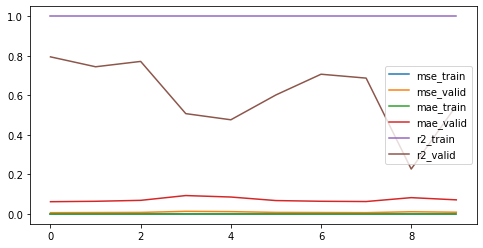

In [7]:
ax = pd.DataFrame(default_model_scores_ori).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [8]:
# search space for the hyperparameters
space = [Integer(1, 50, name='max_depth'),
         Integer(2, 200, name='min_samples_split'),
         Integer(1, 200, name='min_samples_leaf')]

Optimal point: [5, 3, 6]
Function value at optimal point: 0.004838522672233154


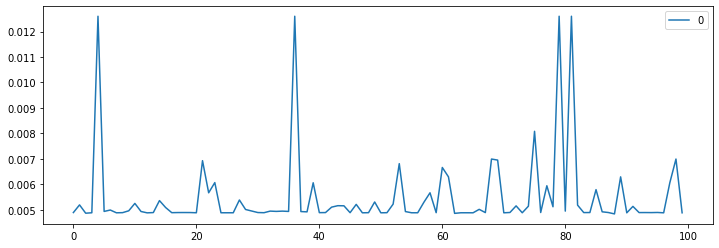

In [9]:
# objective function to minimize
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    model = ml_algorithm(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_ori')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='auto', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [10]:
# ---------------- config opt model -----------------
opt_model_ori = ml_algorithm(max_depth=5, min_samples_split=3, min_samples_leaf=6, random_state=23)

In [11]:
opt_model_ori_tscv_scores = cross_validation(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_tscv_scores = pd.DataFrame(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.003462,0.002750,0.046419,0.041385,0.858521,0.909999
1,0.003360,0.003974,0.045302,0.049370,0.874424,0.852475
2,0.003198,0.004785,0.044202,0.055959,0.883537,0.855677
3,0.003355,0.009243,0.045407,0.081061,0.887808,0.648147
4,0.003969,0.008237,0.049431,0.076320,0.866648,0.624358
5,0.004538,0.003151,0.053512,0.043354,0.844772,0.836026
6,0.004491,0.002897,0.053349,0.043194,0.842148,0.879403
7,0.004290,0.002518,0.051977,0.040095,0.849498,0.877656
8,0.003942,0.007593,0.049391,0.071265,0.856561,0.461428
9,0.004318,0.003236,0.052034,0.045374,0.838739,0.827112


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003892,0.004839,0.049102,0.054738,0.860266,0.777228
std,0.000512,0.002543,0.003557,0.015654,0.017339,0.147451
min,0.003198,0.002518,0.044202,0.040095,0.838739,0.461428
25%,0.003385,0.002961,0.045660,0.043234,0.845954,0.692888
50%,0.003956,0.003605,0.049411,0.047372,0.857541,0.844250
75%,0.004311,0.006891,0.052020,0.067439,0.872480,0.872162
max,0.004538,0.009243,0.053512,0.081061,0.887808,0.909999


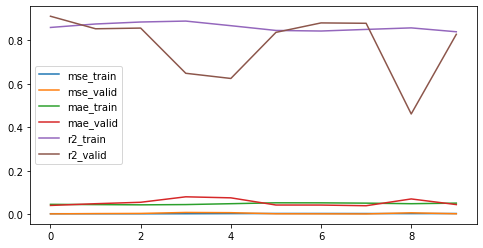

In [12]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

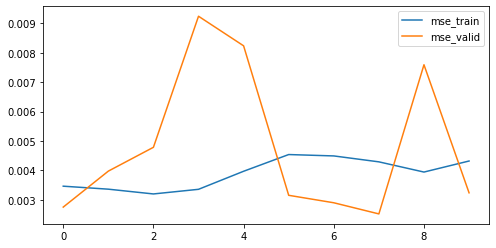

In [13]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

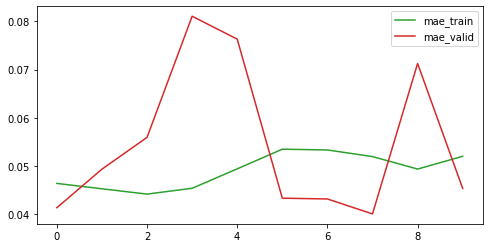

In [14]:
ax = opt_model_ori_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

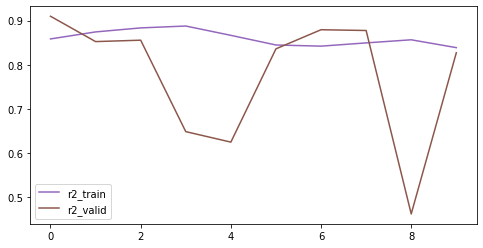

In [15]:
ax = opt_model_ori_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [16]:
opt_model_ori_test_scores = performance_test_shifted(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_test_scores = pd.DataFrame(opt_model_ori_test_scores)
display(opt_model_ori_test_scores)
display(opt_model_ori_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003366,0.003987,0.045315,0.049329,0.873630,0.851994,0.366445,0.388259
1,0.003405,0.004790,0.045593,0.056255,0.875471,0.855517,0.425448,0.397883
2,0.003363,0.009063,0.045507,0.080384,0.887208,0.655002,0.330819,0.390371
3,0.004005,0.008022,0.049888,0.075251,0.863791,0.634136,0.286654,0.353382
4,0.004425,0.003207,0.052808,0.043693,0.847819,0.833144,0.281294,0.289533
5,0.004332,0.002887,0.052124,0.043173,0.847034,0.879857,0.288558,0.275418
6,0.004235,0.002556,0.051638,0.040268,0.849684,0.875827,0.291026,0.288823
7,0.004062,0.007838,0.050243,0.072648,0.853215,0.444098,0.199579,0.262697
8,0.004290,0.003221,0.051669,0.045223,0.844491,0.827941,0.245124,0.235445
9,0.004174,0.003331,0.051099,0.046677,0.840386,0.839945,0.245513,0.221362


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003966,0.004890,0.049588,0.055290,0.858273,0.769746,0.296046,0.310317
std,0.000424,0.002455,0.002963,0.015087,0.015791,0.144313,0.064764,0.066587
min,0.003363,0.002556,0.045315,0.040268,0.840386,0.444098,0.199579,0.221362
25%,0.003555,0.003210,0.046666,0.044075,0.847230,0.698236,0.254458,0.265877
50%,0.004118,0.003659,0.050671,0.048003,0.851449,0.836545,0.287606,0.289178
75%,0.004277,0.007076,0.051661,0.068550,0.871170,0.854636,0.320871,0.379540
max,0.004425,0.009063,0.052808,0.080384,0.887208,0.879857,0.425448,0.397883


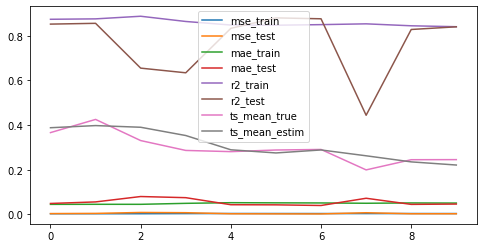

In [17]:
ax = opt_model_ori_test_scores.plot(figsize=(8,4))

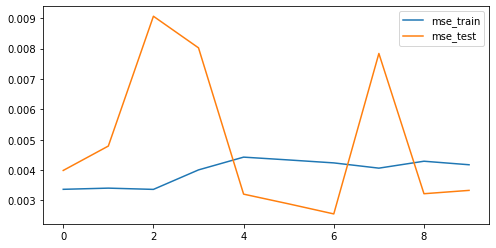

In [18]:
ax = opt_model_ori_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

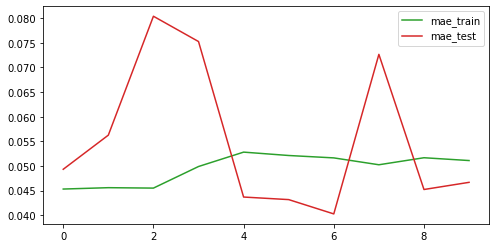

In [19]:
ax = opt_model_ori_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

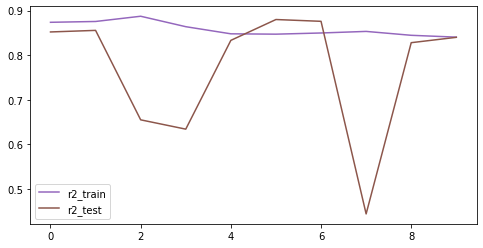

In [20]:
ax = opt_model_ori_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

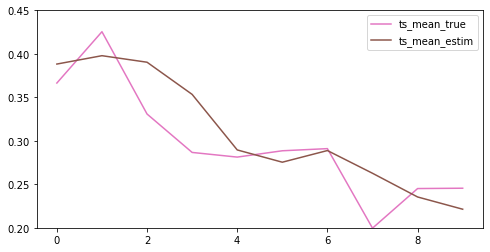

In [21]:
ax = opt_model_ori_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [22]:
results_ori = {'Model': [opt_model_ori],
            'fc_horizon': 0,
            'vif': [vif],
            'mse_tscv_t': [opt_model_ori_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_ori_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_ori_test_scores.mse_train.mean()],
            'mse_test': [opt_model_ori_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_ori_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_ori_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_ori_test_scores.mae_train.mean()],
            'mae_test': [opt_model_ori_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_ori_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_ori_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_ori_test_scores.r2_train.mean()],
            'r2_test': [opt_model_ori_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_ori.get_params()],
            'ts_mean_true': opt_model_ori_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_ori_test_scores.ts_mean_estim.mean(),
              }

## ----------------------------------------------------------
## Predicted Target Model (one year forecast horizon)
### Time Series Cross Validation on Default Model

In [23]:
default_model_scores_hor = cross_validation (data_set, default_model, 'tau_target_hor')
pd.DataFrame(default_model_scores_hor).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,0.015925,0.0,0.098510,1.0,0.241675
std,0.0,0.003599,0.0,0.013156,0.0,0.295382
min,0.0,0.011960,0.0,0.083238,1.0,-0.463978
25%,0.0,0.013118,0.0,0.088451,1.0,0.128666
50%,0.0,0.014914,0.0,0.096095,1.0,0.330781
75%,0.0,0.018837,0.0,0.108775,1.0,0.401724
max,0.0,0.022139,0.0,0.122823,1.0,0.538911


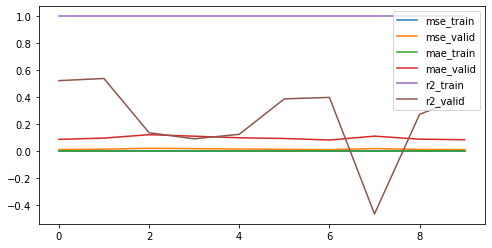

In [24]:
ax = pd.DataFrame(default_model_scores_hor).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

Optimal point: [6, 142, 6]
Function value at optimal point: 0.009485179225569974


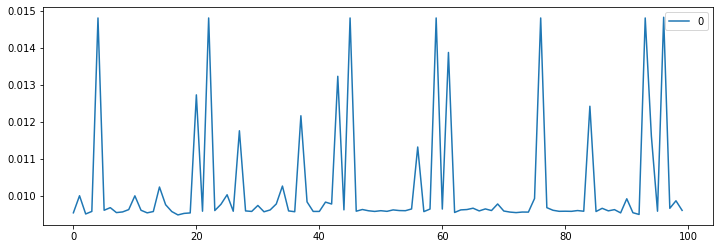

In [25]:
# objective function to minimize
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    model = ml_algorithm(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_hor')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='auto', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [26]:
# ---------------- config opt model -----------------
opt_model_hor = ml_algorithm(max_depth=6, min_samples_split=142, min_samples_leaf=6, random_state=23)

In [27]:
opt_model_hor_tscv_scores = cross_validation(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_tscv_scores = pd.DataFrame(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.006647,0.007044,0.065395,0.064508,0.744292,0.741184
1,0.006433,0.009476,0.063661,0.079869,0.760423,0.715794
2,0.006708,0.015469,0.065086,0.104420,0.772397,0.397431
3,0.007689,0.013719,0.070200,0.099502,0.738512,0.363100
4,0.008304,0.010242,0.073604,0.082685,0.712445,0.463329
5,0.008351,0.007050,0.073571,0.067329,0.703530,0.701546
6,0.008224,0.005740,0.072805,0.059749,0.707789,0.711582
7,0.007440,0.014101,0.068679,0.099693,0.724138,-0.019583
8,0.007405,0.006262,0.068224,0.063485,0.719357,0.663846
9,0.007111,0.005749,0.066163,0.060581,0.717072,0.721324


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.007431,0.009485,0.068739,0.078182,0.729995,0.545955
std,0.000710,0.003740,0.003695,0.017636,0.023134,0.246173
min,0.006433,0.005740,0.063661,0.059749,0.703530,-0.019583
25%,0.006809,0.006457,0.065587,0.063741,0.713602,0.413905
50%,0.007422,0.008263,0.068451,0.073599,0.721748,0.682696
75%,0.008090,0.012850,0.072154,0.095298,0.742847,0.714741
max,0.008351,0.015469,0.073604,0.104420,0.772397,0.741184


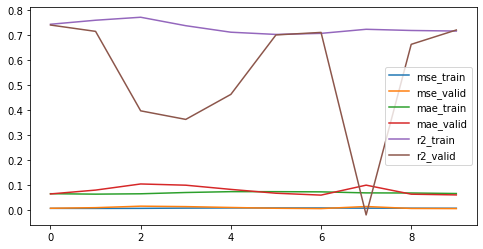

In [28]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

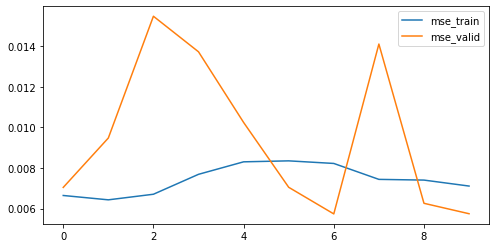

In [29]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

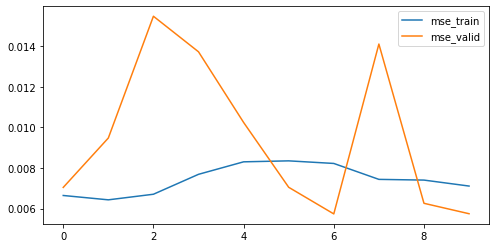

In [30]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

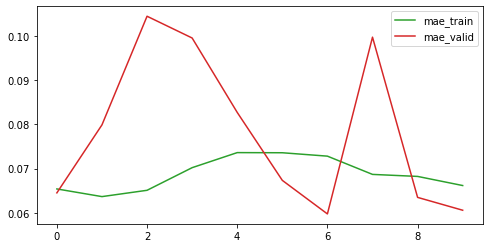

In [31]:
ax = opt_model_hor_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

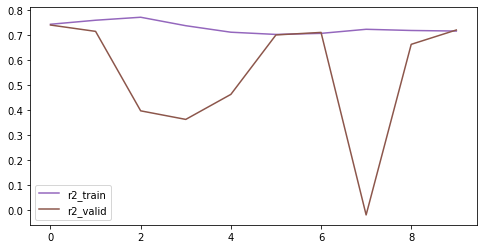

In [32]:
ax = opt_model_hor_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [33]:
opt_model_hor_test_scores = performance_test_shifted(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_test_scores = pd.DataFrame(opt_model_hor_test_scores)
display(opt_model_hor_test_scores)
display(opt_model_hor_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.006543,0.009875,0.064541,0.080496,0.754694,0.703817,0.429797,0.385580
1,0.006713,0.015619,0.065243,0.104844,0.771297,0.391611,0.335499,0.414149
2,0.007467,0.013557,0.069235,0.098879,0.741855,0.370621,0.293080,0.381567
3,0.008082,0.009512,0.072399,0.078843,0.717960,0.501573,0.287144,0.349415
4,0.008322,0.006636,0.073404,0.065211,0.702286,0.719102,0.295090,0.317119
5,0.008143,0.005908,0.072458,0.059563,0.707678,0.703132,0.292463,0.310195
6,0.007780,0.016331,0.070327,0.107729,0.714789,-0.180813,0.205042,0.307100
7,0.007962,0.006495,0.071139,0.064598,0.705801,0.651327,0.247086,0.260466
8,0.007183,0.005715,0.066981,0.060538,0.721544,0.722960,0.248710,0.242956
9,0.006917,0.018799,0.065742,0.119823,0.720973,-0.007763,0.342639,0.230163


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.007511,0.010845,0.069147,0.084052,0.725888,0.457557,0.297655,0.319871
std,0.000641,0.004871,0.003296,0.022156,0.022774,0.322357,0.062015,0.062930
min,0.006543,0.005715,0.064541,0.059563,0.702286,-0.180813,0.205042,0.230163
25%,0.006983,0.006530,0.066052,0.064751,0.709456,0.375868,0.258318,0.272125
50%,0.007624,0.009694,0.069781,0.079670,0.719466,0.576450,0.292772,0.313657
75%,0.008052,0.015103,0.072084,0.103353,0.736777,0.703646,0.325397,0.373529
max,0.008322,0.018799,0.073404,0.119823,0.771297,0.722960,0.429797,0.414149


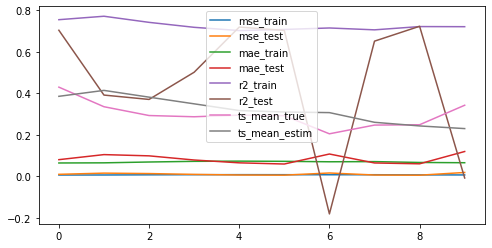

In [34]:
ax = opt_model_hor_test_scores.plot(figsize=(8,4))

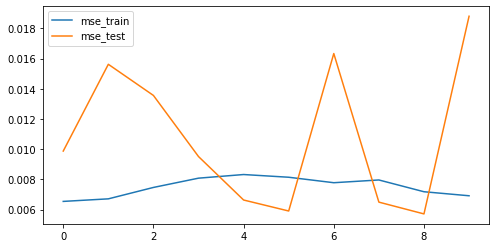

In [35]:
ax = opt_model_hor_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

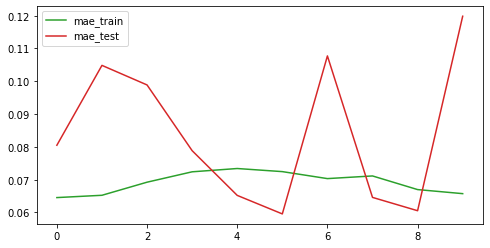

In [36]:
ax = opt_model_hor_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

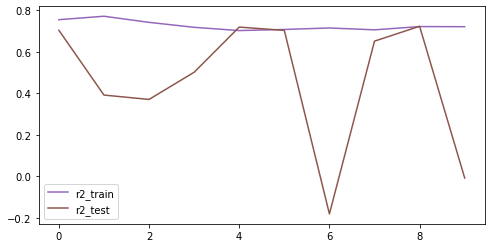

In [37]:
ax = opt_model_hor_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

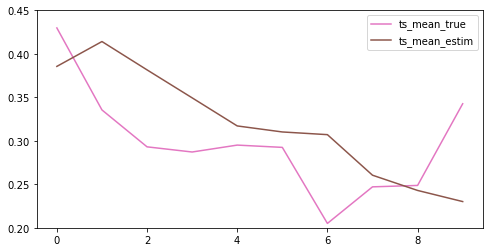

In [38]:
ax = opt_model_hor_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [39]:
results_hor = {'Model': [opt_model_ori],
            'fc_horizon': 1,
            'vif': [vif],
            'mse_tscv_t': [opt_model_hor_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_hor_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_hor_test_scores.mse_train.mean()],
            'mse_test': [opt_model_hor_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_hor_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_hor_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_hor_test_scores.mae_train.mean()],
            'mae_test': [opt_model_hor_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_hor_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_hor_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_hor_test_scores.r2_train.mean()],
            'r2_test': [opt_model_hor_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_hor.get_params()],
            'ts_mean_true': opt_model_hor_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_hor_test_scores.ts_mean_estim.mean(),
              }

## Safe to Excel

In [40]:
results = pd.concat([pd.DataFrame(results_ori), pd.DataFrame(results_hor)])

display(results)

storage_name = filename + '_' + vif + '_' + str(datetime.today().day) + '.xlsx'

pd.DataFrame(results).to_excel(path + 'artifacts' + slash + storage_name, index=None)

,Model,fc_horizon,vif,mse_tscv_t,mse_tscv_v,mse_train,mse_test,mae_tscv_t,mae_tscv_v,mae_train,mae_test,r2_tscv_t,r2_tscv_v,r2_train,r2_test,opt_model,ts_mean_true,ts_mean_estim
0,"DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=3,\n random_state=23)",0,all,0.003892,0.004839,0.003966,0.004890,0.049102,0.054738,0.049588,0.055290,0.860266,0.777228,0.858273,0.769746,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}",0.296046,0.310317
0,"DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=3,\n random_state=23)",1,all,0.007431,0.009485,0.007511,0.010845,0.068739,0.078182,0.069147,0.084052,0.729995,0.545955,0.725888,0.457557,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 142, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}",0.297655,0.319871
